In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
input_path = '../data-sim/Town05_2240'
output_path = '../figures'

FILE_FORMAT = 'png'

In [3]:
json_data_actor = json.load(open(f'{input_path}/data_actor.json', 'rb'))
df_actor = pd.json_normalize(json_data_actor, record_path=['actors'])

In [4]:
json_data_relationship = json.load(open(f'{input_path}/data_relationship.json', 'rb'))
df_relationships = pd.json_normalize(json_data_relationship, record_path=['relationships'])

In [5]:
def agg_attempt_collision_near_miss(data):
    d = {}
    d['attempts'] = data['num_collisions'].count()
    d['preventative-meausere'] = (data['num_preventative_maneuvers'] > 0).sum()
    d['collisions'] = data['num_collisions'].sum()
    d['>0-near-miss-occured'] = data['near_miss_occurance'].sum()
    return pd.Series(d)

In [6]:
def create_bar_chart(df, groupby, title, width, height, output_path):
    df_agg = df.groupby([groupby]).apply(agg_attempt_collision_near_miss)
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(width, height))
    # Extracting data for plotting
    categories = df_agg.index
    attributes = ['attempts', 'preventative-meausere', 'collisions', '>0-near-miss-occured']
    data = df_agg[attributes].values

    # Set the bar width
    bar_width = 0.2

    # Create positions for bars
    x = range(len(categories))
    x_attempts = x
    x_measure = [i + bar_width for i in x]
    x_collisions = [i + 2 * bar_width for i in x]
    x_near_miss = [i + 3 * bar_width for i in x]

    # Create the bars
    plt.bar(x_attempts, data[:, 0], width=bar_width, label='attempts')
    plt.bar(x_measure, data[:, 1], width=bar_width, label='preventative-meausere')
    plt.bar(x_collisions, data[:, 2], width=bar_width, label='collisions')
    plt.bar(x_near_miss, data[:, 3], width=bar_width, label='>0-near-miss-occured')

    # Set x-axis labels
    plt.xticks([i + (len(attributes) - 1) / 2 * bar_width for i in x], categories)

    # Set the title and legend
    plt.title(title)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    # plt.show()

    # Save the plot
    plt.savefig(f'{output_path}/{title}.{FILE_FORMAT}')

In [7]:
plot_types = [
    (df_actor[df_actor['ego']],                                  'maneuver.id',               'ego____specific Ego attempts per maneuver'                           ),
    (df_actor[df_actor['ego']],                                  'maneuver.type',             'ego________type Ego attempts per maneuver type'                      ),
    (df_actor[df_actor['ego']],                                  'maneuver.start_lane_id',    'ego_______start Ego attempts per start lane'                         ),
    (df_actor[df_actor['ego']],                                  'maneuver.end_lane_id',      'ego_________end Ego attempts per end lane'                           ),
    (df_actor[~df_actor['ego']],                                 'maneuver.id',               'nonego_specific Ego attempts per maneuver'                           ),
    (df_actor[~df_actor['ego']],                                 'maneuver.type',             'nonego_____type Ego attempts per maneuver type'                      ),
    (df_actor[~df_actor['ego']],                                 'maneuver.start_lane_id',    'nonego____start Ego attempts per start lane'                         ),
    (df_actor[~df_actor['ego']],                                 'maneuver.end_lane_id',      'nonego______end Ego attempts per end lane'                           ),
    (df_relationships[df_relationships['time'] == 'initial'],    'relationship',              'rel________init Relationship attempts per relationship (initial)'    ),
    (df_relationships[df_relationships['time'] == 'final'],      'relationship',              'rel_______final Relationship attempts per relationship (final)'      ),
    (df_actor[df_actor['ego']],                                  'num_actors',                'Ego attempts per number of actors'      ),
]

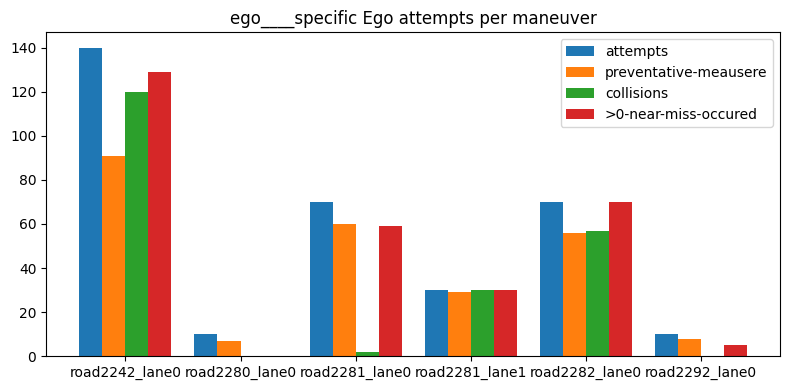

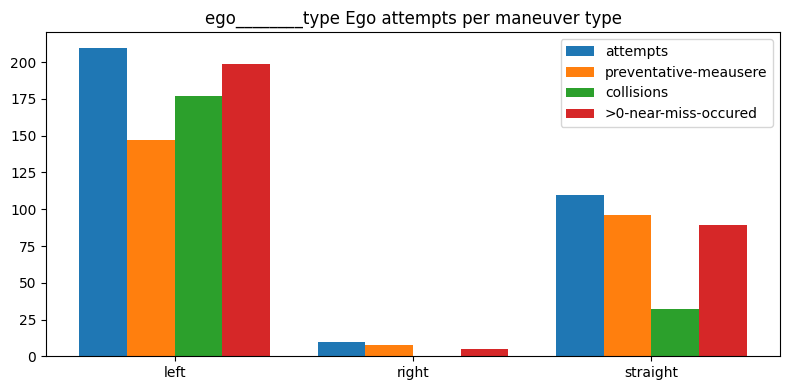

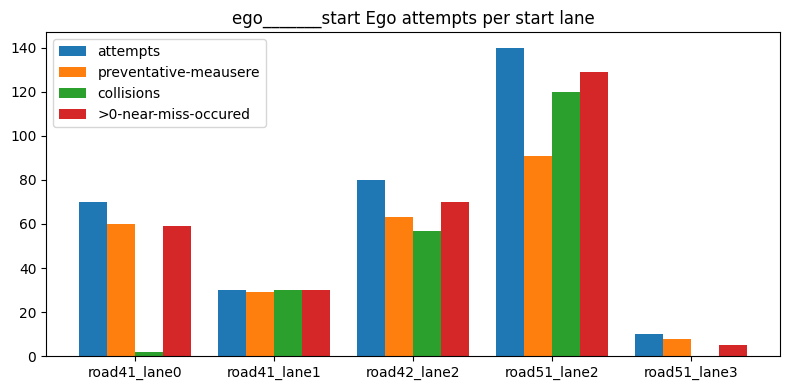

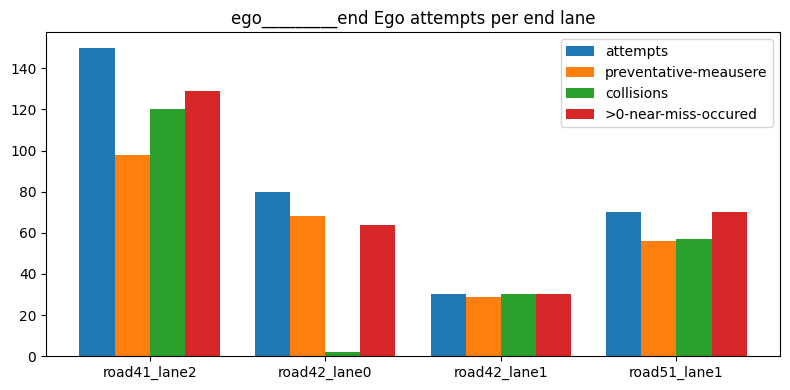

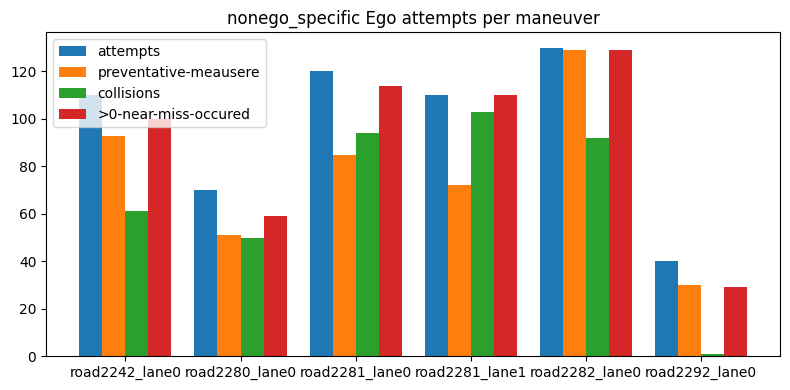

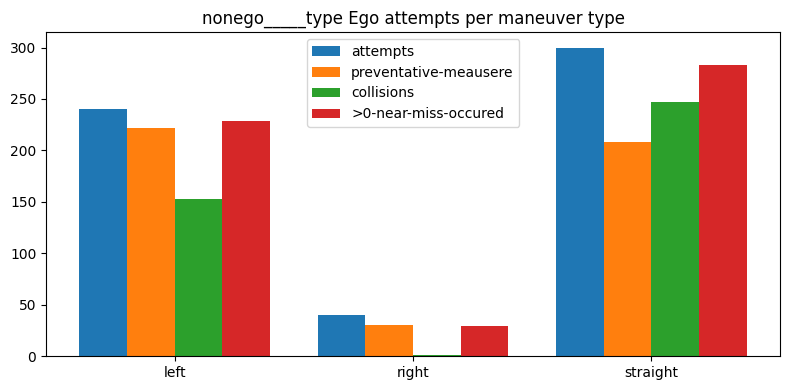

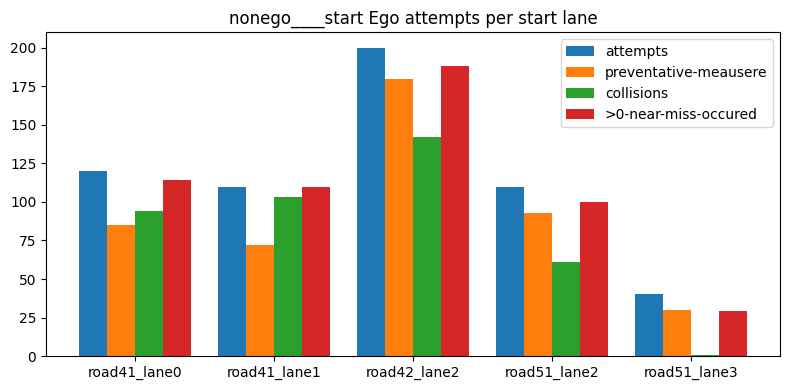

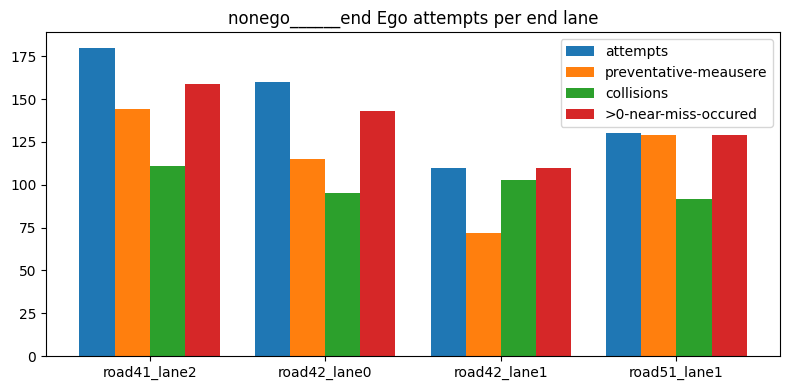

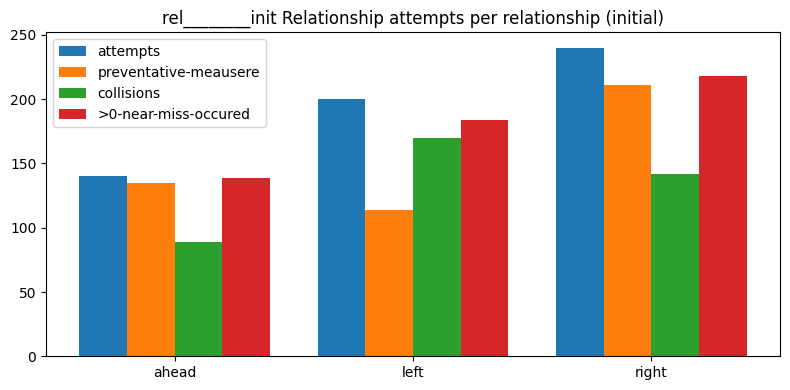

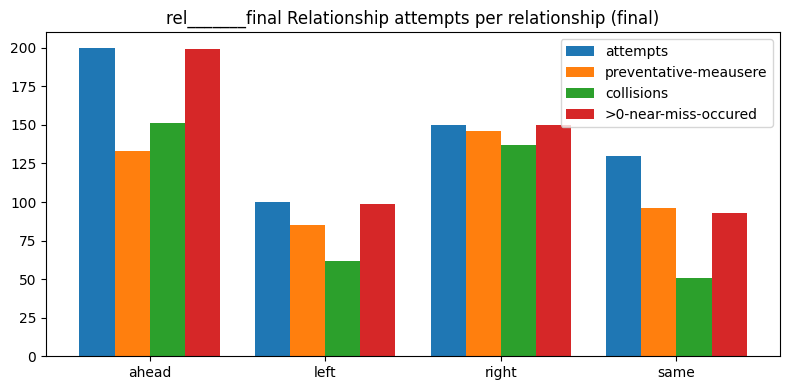

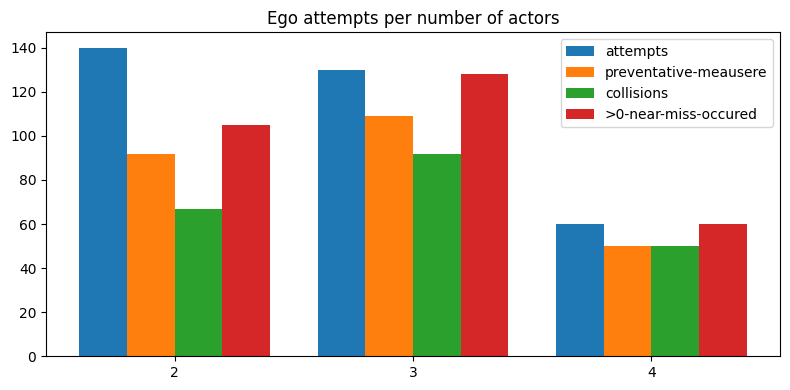

In [8]:
for df, groupby, title in plot_types:
        create_bar_chart(df, groupby, title, 8, 4, output_path)

In [9]:
df_coords = pd.read_csv(f'{input_path}/path_coords.csv')

<Axes: xlabel='x', ylabel='y'>

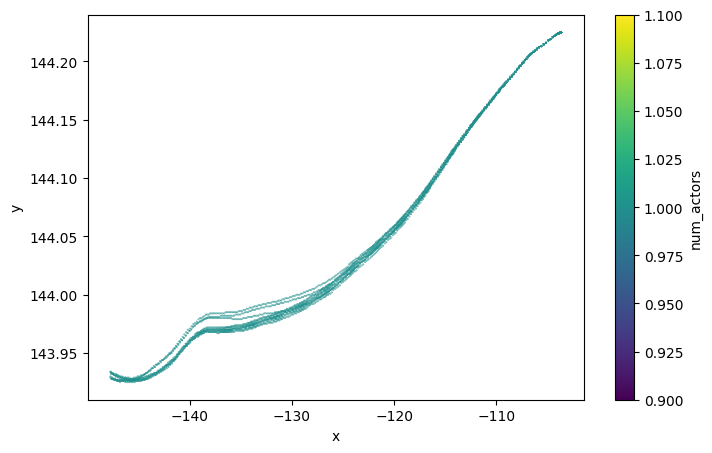

In [10]:
df_coords[(df_coords['num_actors'] == 1) & (df_coords['man_id'] == 'road2281_lane0')].plot.scatter(x='x', y='y', c='num_actors', colormap='viridis', s=0.1, figsize=(8, 5))

In [29]:
def create_coordinates_chart(df, man_id, title, fix_scale=False):
    # Filter the DataFrame based on the condition 'man_id'
    filtered_df = df[df['man_id'] == man_id]

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    if fix_scale:
        ax.set_aspect('equal', adjustable='box')

    # Define discrete colors for each unique 'num_actors' value
    unique_num_actors = filtered_df['num_actors'].unique()
    colors = plt.cm.tab10.colors[:len(unique_num_actors)]

    # Create a legend handler map for dot markers
    legend_handles = []
    for num_actor, color in zip(unique_num_actors, colors):
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=f'num_actors={num_actor}'))

    # Create the scatter plot with discrete colors
    for num_actor, color in zip(unique_num_actors, colors):
        subset_df = filtered_df[filtered_df['num_actors'] == num_actor]
        ax.scatter(subset_df['x'], subset_df['y'], label=f'num_actors={num_actor}', color=color, alpha=0.2, s=5)

    # Set the title
    ax.set_title(title)

    # Add the legend with dot markers
    ax.legend(handles=legend_handles)

    if fix_scale and ('80' in man_id or '81' in man_id):
        # Adjust the y-axis limits to cover more area
        ax.set_ylim(bottom=min(filtered_df['y']) - 5, top=max(filtered_df['y']) + 10)  # You can adjust the padding as needed

    # Add axis titles
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    # Show the plot
    # plt.show()

    # Save the plot
    plt.savefig(f'{output_path}/{title}.{FILE_FORMAT}')

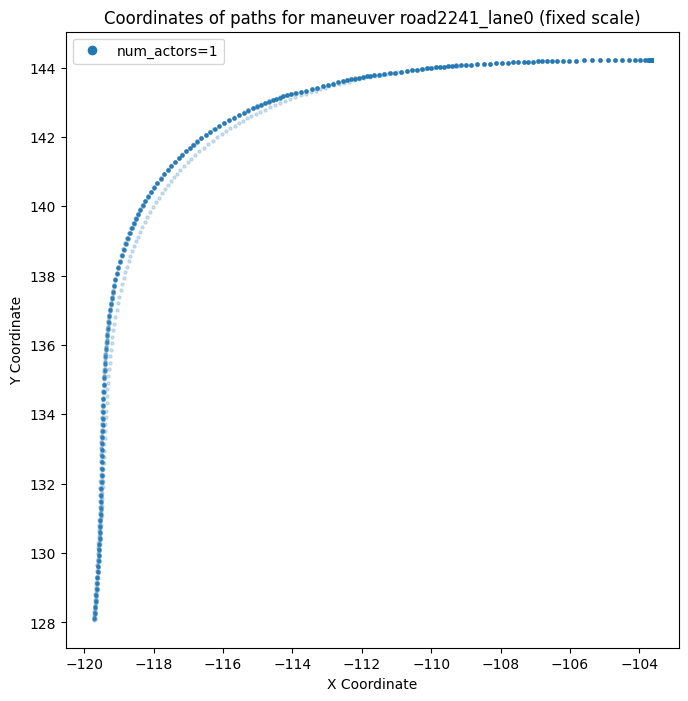

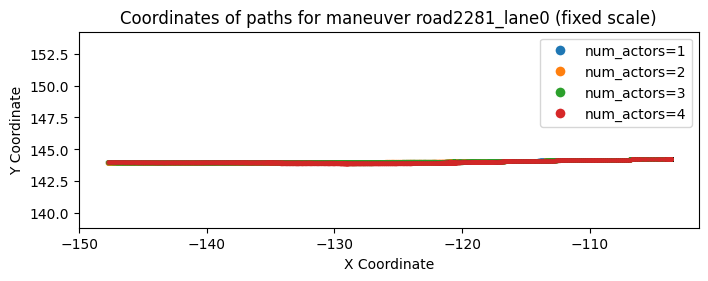

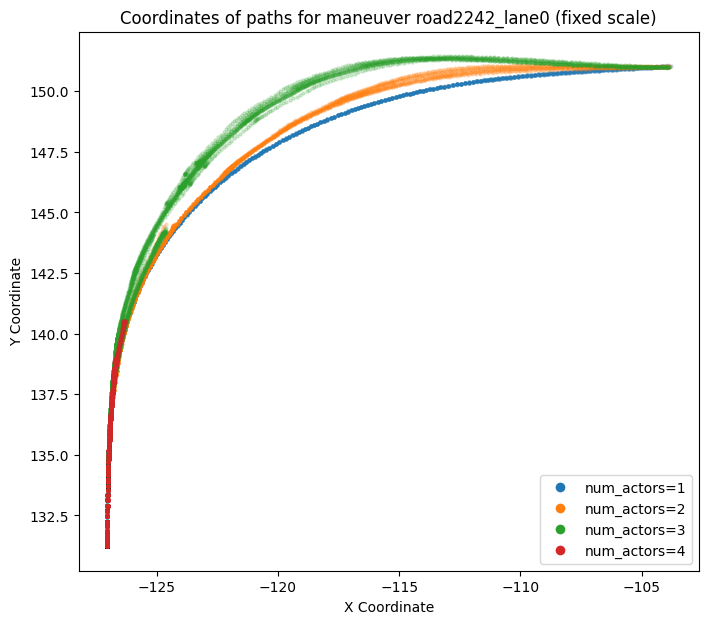

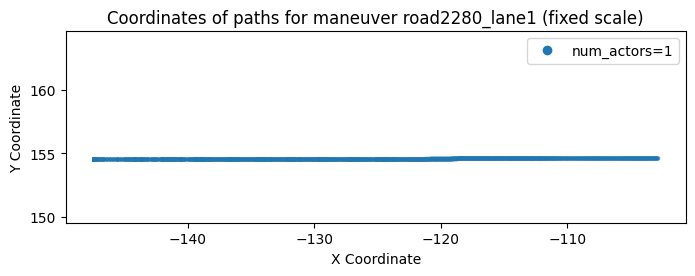

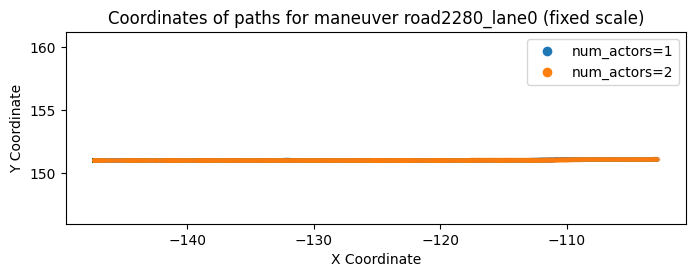

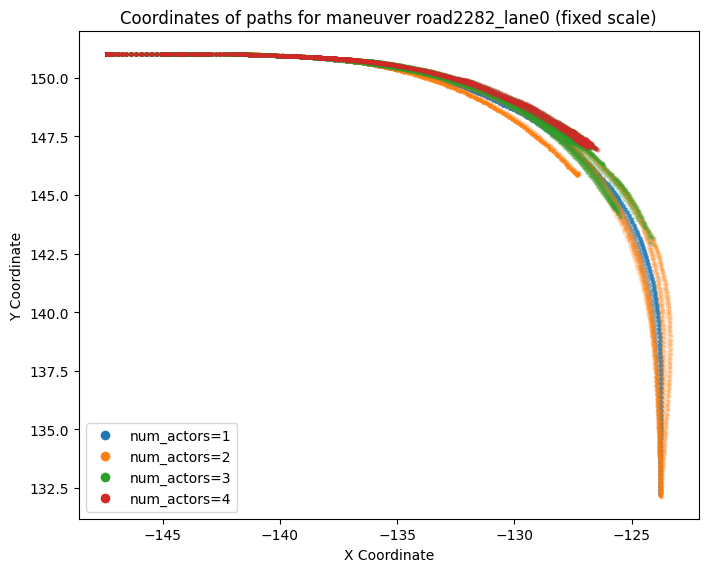

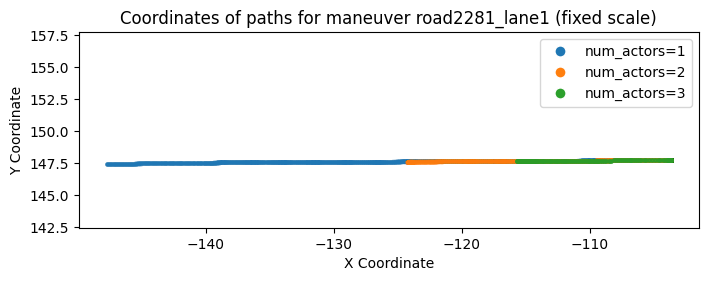

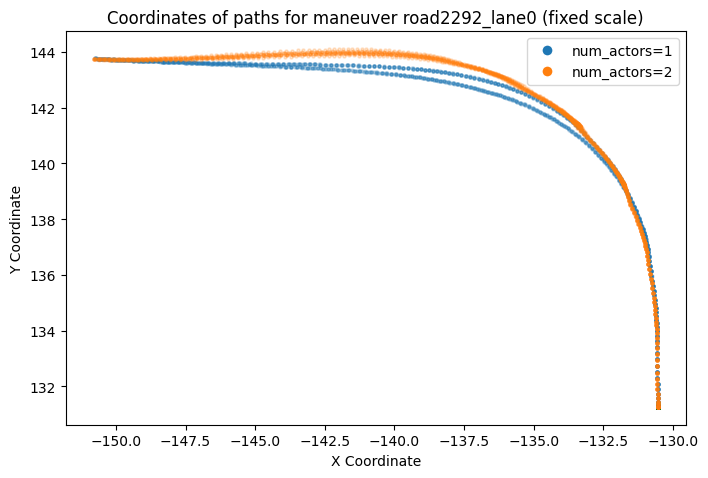

In [30]:
# iterate through man_id values in df_coords
for man_id in df_coords['man_id'].unique():
    create_coordinates_chart(df=df_coords, man_id=man_id, title=f'Coordinates of paths for maneuver {man_id}', fix_scale=True)


In [13]:
test = []
test.append({'num_actors': 1, 'x': 1, 'y': 2})
test.append({'num_actors': 1, 'x': 2, 'y': 3})
test.append({'num_actors': 2, 'x': 3, 'y': 4})
test.append({'num_actors': 1, 'x': 4, 'y': 5})
df_test = pd.DataFrame(test)

In [14]:
fig = px.scatter(df_coords[(df_coords['man_id'] == 'road2281_lane0')], x='x', y='y', color='num_actors', opacity=0.2, title='Path Coordinates', width=800, height=800)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
  )
fig.show()